Credits:  
[Autoformer](https://github.com/thuml/Autoformer)  
[FEDformer](https://github.com/MAZiqing/FEDformer)  

In [64]:
from types import SimpleNamespace
cfg = {
    # DATA
    'dataset_id':0,
    'step':20, # step input output 
    # 'target_len':20, # same for now

    # MODEL
    'd_model':2,
    'n_heads':1,
    'batch_size':1,
    'seq_len':100,
}
cfg = SimpleNamespace(**cfg)

# PART WHERE DATA HAPPENS 

In [15]:
import os
import torch
from scipy.io.wavfile import read
import matplotlib.pyplot as plt


In [16]:
base_paths = [
    '../data/music_data/VBB_DRUM_HITS/VBB_KICKS/',
    '../data/music_data/SOPHIE_sample_library/SOPHIE_one_shots/SOPHIE_drums/SOPHIE_kicks/all_kicks',
    '../data/music_data/Drums/Kicks',
    ]


Challenges:
1. Length of the signal
2. Scale or magnitude of the data 

In [17]:
'''
For each dataset, 
Store mean and std for z-score normalization
'''
mean_std_files = [
    'VBB_KICKS_zmean_zstd.yaml',
    'SOPHIE_zmean_zstd.yaml',
    'Drums_zmean_zstd.yaml'
    ]

z_scale = {}

for i, zs_file in enumerate(mean_std_files):
    z_mean = []
    z_std = []

    path = base_paths[i]
    
    if not os.path.exists(zs_file):
        filenames = os.listdir(path)
        filepaths = [os.path.join(path, fn) for fn in filenames]
        signals = []
        for fp in filepaths: 
            _, signal = read(fp)
            signal = torch.tensor(signal).flatten().float()
            signals += [signal]

        signals = torch.concat(signals, -1)
        z_mean = signals.mean().item()
        z_std = signals.std().item()

        # save values
        with open(zs_file, 'w') as f:
            f.write('z_mean:'+str(z_mean)+'\n')
            f.write('z_std:'+str(z_std))
            
        z_scale[zs_file] = [z_mean, z_std]
    
    # if files already exist
    else:
        with open(zs_file, 'r') as f:
            z_file = f.read()
        
        z_file = z_file.split('\n')
        z_mean = float(z_file[0].split(':')[1])
        z_std = float(z_file[1].split(':')[1])
        # print(z_mean, z_std)
        z_scale[zs_file] = [z_mean, z_std]


In [18]:
z_scale

{'VBB_KICKS_zmean_zstd.yaml': [-561862.3125, 459715136.0],
 'SOPHIE_zmean_zstd.yaml': [30967.67578125, 538729664.0],
 'Drums_zmean_zstd.yaml': [3.824542284011841, 11310.7451171875]}

In [69]:
class Dataset:
    def __init__(self, path, cfg, z_scale):
        filepaths = self._get_filepaths(path)
        self.samples = self._get_samples(filepaths, cfg, z_scale)
        self._len = len(self.samples)

    def __getitem__(self, idx):
        source = self.samples[idx]
        target = source
        return source, target

    def __len__(self):
        return self._len

    def _get_filepaths(self, path):
        filenames = os.listdir(path)

        filepaths = [os.path.join(path, fn) for fn in filenames]
        return filepaths 

    def _get_samples(self, filepaths, cfg, z_scale):
        samples = []
        z_mean = z_scale[0]
        z_std = z_scale[1]

        for path in filepaths:
            _, signal = read(path)
            signal = (torch.tensor(signal) - z_mean) / z_std
            position = torch.arange(signal[:,0].size()[0]).unsqueeze(-1)
            signal = torch.concat((signal, position), -1)

            # Separate signal to samples
            for i in range(0, signal.shape[0]-cfg.step, cfg.step):
                # print(signal.shape[0],i,i+cfg.step)
                samples += [signal[i:i+cfg.step]]
        return samples

In [82]:
ds_path = base_paths[cfg.dataset_id]

key = list(z_scale.keys())[cfg.dataset_id]
ds_z_scale = z_scale[key]

train_ds = Dataset(ds_path, cfg, ds_z_scale)

/tmp/ipykernel_122606/1586169513.py:27: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, signal = read(path)


In [84]:
a,b = train_ds[0]
a.shape, b.shape, len(train_ds)

(torch.Size([20, 3]), torch.Size([20, 3]), 192141)

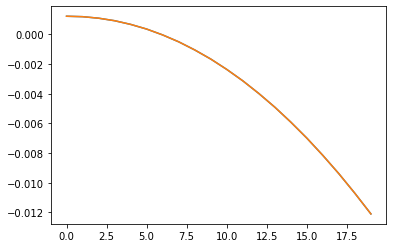

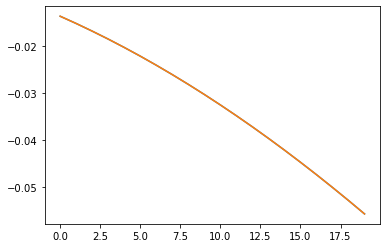

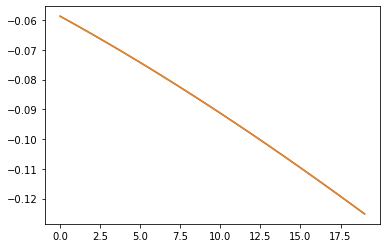

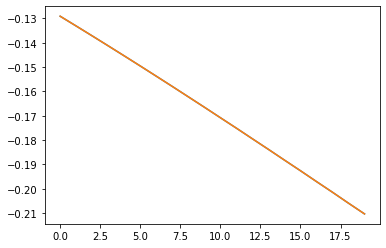

In [85]:
key = list(z_scale.keys())[cfg.dataset_id]

for i in range(4):
    zmean = z_scale[key][0]
    zstd = z_scale[key][1]
    # print(ds[i].shape)
    plt.figure()
    # plt.plot(ds[i])
    # plt.plot((ds[i][0][:,:2] - zmean) / zstd)
    plt.plot(train_ds[i][0][:,:2])
    plt.show()

In [86]:
from torch.utils.data import DataLoader 
train_dl = DataLoader(train_ds, batch_size=64, drop_last=True)

# PART WHERE MODEL HAPPENS 

In [8]:
import torch
import torch.nn as nn

my_dummy_data = torch.rand(cfg.batch_size, cfg.seq_len, cfg.d_model)
my_dummy_data.shape

torch.Size([1, 100, 2])

In [46]:
from autocorrelation import AutoCorrelationLayer, AutoCorrelation

class SmalModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        auto_correletion = AutoCorrelation(
            factor=1, # used for top_k prediction thing
            attention_dropout=0.05,
            output_attention=True,

            scale=None, # does nothing (never used)
            mask_flag=True, # does nothing (never used)
        )

        emb_dim = 2
        self.f1 = nn.Linear(cfg.d_model, emb_dim)

        self.autocorr_layer = AutoCorrelationLayer(
            correlation=auto_correletion,
            d_model=emb_dim,
            n_heads=cfg.n_heads,
            d_keys=None) # Why we not use it? who knows
    
        self.f2 = nn.Linear(emb_dim, cfg.d_model)

    def forward(self, x, attn_mask=None):

        x = self.f1(x)

        x,corr = self.autocorr_layer(x,x,x, attn_mask)

        x = self.f2(x)

        return x, corr

In [47]:
data = ds[0][:cfg.seq_len].unsqueeze(0).float() / 10000
data.shape

torch.Size([1, 100, 2])

In [48]:
model = SmalModel(cfg)

In [49]:
from tqdm import tqdm
criterion_mse =  nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), 1e-3)

losses = []
for epoch in tqdm(range(100)):
    out,_ = model(data)

    loss = criterion_mse(out, data)
    loss.backward()
    opt.step()

    losses += [loss.item()]
    # print(loss.item())

100%|██████████| 100/100 [00:00<00:00, 202.36it/s]


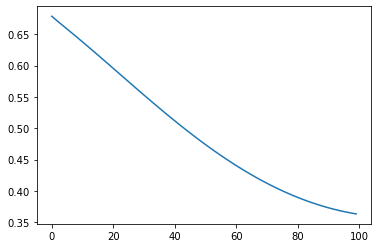

In [50]:
plt.plot(losses)
# plt.yscale('log')

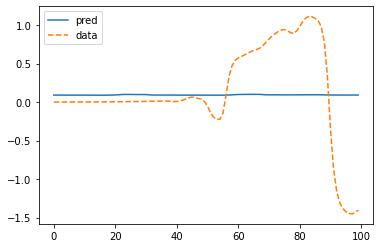

In [51]:
plt.figure()
plt.plot(out.detach()[0][:,0], label='pred')
plt.plot(data[0,:,0], '--', label='data')
plt.legend()
plt.show()
